Probabilistic Programming in 3 Examples
======
______

Probabilistic programming makes Bayesian inference easy to do.  Recent advancements in inference algorithms like NUTS[1] and ADVI[2] have made probabilistic programming a reality.  We will look at 3 examples in PyMC3 to illustrate the use for probabilistic programming.

These examples are taken other brilliant hackers and I take zero credit.  If you have time, I highly recommend reading "Bayesian Methods for Hackers"[3] and "Probabilistic programming in Python using PyMC3"[4].  Thanks to Fast Forward Labs[5] for letting me review their research on the topic.

p.s - if you want to run the code as you go along, I suggest installing the dev version of pymc3 from github (otherwise I ran into performance issues, at least on my 3yo macbook) 

`pip install git+https://github.com/pymc-devs/pymc3`


##### Bayesian Inference and Probabilistic Programming
For the uninitiated, Bayesian inference allows you to build statistical models with ease and quantify uncertainties in your predictions.  It also allows you to specify prior/domain knowledge to influence the predictions.  While still new and not lacking in shortcomings, probabilistic programming gives us great tools for avoiding some common pitfalls in data science.

The following 3 examples will hopefully illustrate the use for this approach.

## Example1: Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily *learned* this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural. 

#### A Simple Case

For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [1]:
import pymc3 as pm
import scipy.stats as stats
import numpy as np

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

/Users/erictang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [2]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ..., 0 0 0]
77


The observed frequency is:

In [3]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % occurrences.mean())
print("Does this equal the true frequency? %s" % (occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0513
Does this equal the true frequency? False


We combine the observations into the PyMC `observed` variable, and run our inference algorithm:

In [4]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|██████████| 18000/18000 [00:01<00:00, 10912.08it/s]


We plot the posterior distribution of the unknown $p_A$ below:

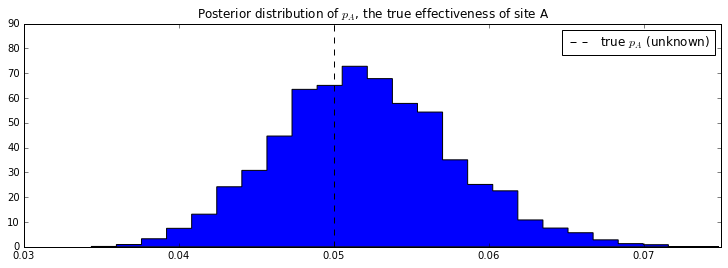

In [5]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.

### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using PyMC's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data )

In [6]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

('Obs from Site A: ', array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0]), '...')
('Obs from Site B: ', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0]), '...')


In [7]:
print(observations_A.mean())
print(observations_B.mean())

0.0453333333333
0.0386666666667


In [8]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

100%|██████████| 20000/20000 [00:03<00:00, 5464.06it/s]


Below we plot the posterior distributions for the three unknowns: 

In [9]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

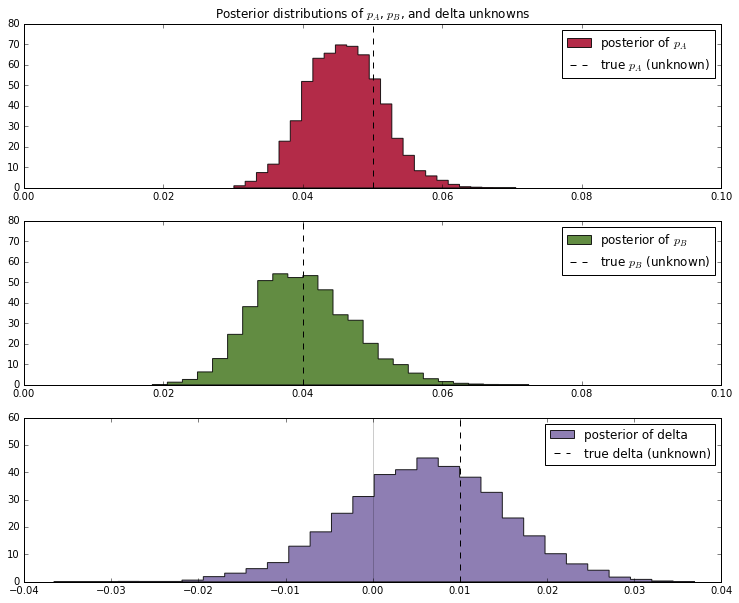

In [10]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [11]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.252
Probability site A is BETTER than site B: 0.748


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Try playing with the parameters `true_p_A`, `true_p_B`, `N_A`, and `N_B`, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

I hope the readers feel this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. Later in this book, we will see two extensions of this model: the first to help dynamically adjust for bad sites, and the second will improve the speed of this computation by reducing the analysis to a single equation.   

## Example2: Stock Market Volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3’s use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

##### The Model

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

\begin{aligned}
  \sigma &\sim exp(50) \\
  \nu &\sim exp(.1) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^{-2}) \\
  log(y_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}

Here, y is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process s. The individual si are the individual daily log volatilities in the latent log volatility process.

##### The Data
Our data consist of daily returns of the S&P 500 during the 2008 financial crisis.

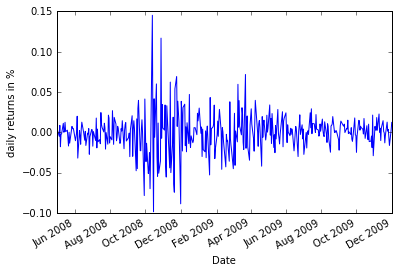

In [2]:
%matplotlib inline

try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas-datareader
    from pandas_datareader import data
    
import pandas as pd
import matplotlib.pyplot as plt

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

returns.plot()
plt.ylabel('daily returns in %');


##### Model Implementation

As with the linear regression example, implementing the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the Exponential distribution for the ν and σ priors, the Student-T (StudentT) distribution for distribution of returns, and the GaussianRandomWalk for the prior for the latent volatilities.

In PyMC3, variables with positive support like Exponential are transformed with a log transform, making sampling more robust. Behind the scenes, the variable is transformed to the unconstrained space (named “variableName_log”) and added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, nu, and the scale parameter for the volatility process, sigma, since they both have exponential priors. Variables with priors that are constrained on both sides, like Beta or Uniform, are also transformed to be unconstrained, here with a log odds transform.

Although (unlike model specification in PyMC2) we do not typically provide starting points for variables at the model specification stage, it is possible to provide an initial value for any distribution (called a “test value” in Theano) using the testval argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are invalid and we want to ensure we select a valid one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden.

The vector of latent volatilities s is given a prior distribution by a GaussianRandomWalk object. As its name suggests, GaussianRandomWalk is a vector-valued distribution where the values of the vector form a random normal walk of length n, as specified by the shape argument. The scale of the innovations of the random walk, sigma, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector.

In [3]:
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk
import pymc3 as pm

with pm.Model() as sp500_model:

    nu = Exponential('nu', 1./10, testval=5.)

    sigma = Exponential('sigma', 1./.02, testval=.1)

    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))

    volatility_process = Deterministic('volatility_process', exp(-2*s))

    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

Notice that we transform the log volatility process s into the volatility process by exp(-2*s). Here, exp is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the Model name sp500_model in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

##### The Fitting


In [4]:
from pymc3 import variational, sample

import scipy
with sp500_model:
    trace = sample(2000)

100%|██████████| 2000/2000 [03:36<00:00, 10.28it/s]


We can check our samples by looking at the traceplot for nu and sigma.



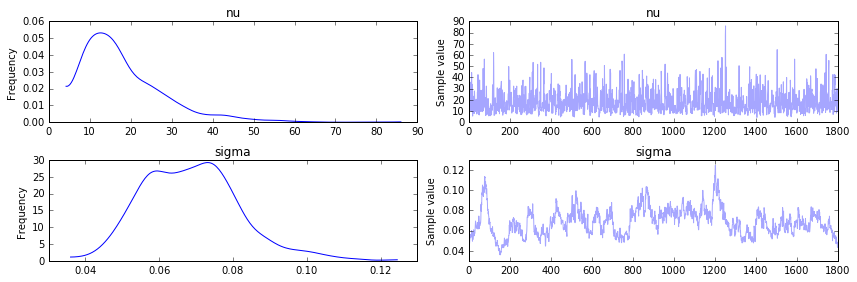

In [5]:
from pymc3 import traceplot

traceplot(trace[200:], [nu, sigma]);


Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is rendered partially transparent (via the alpha argument in Matplotlib’s plot function) so the regions where many paths overlap are shaded more darkly.



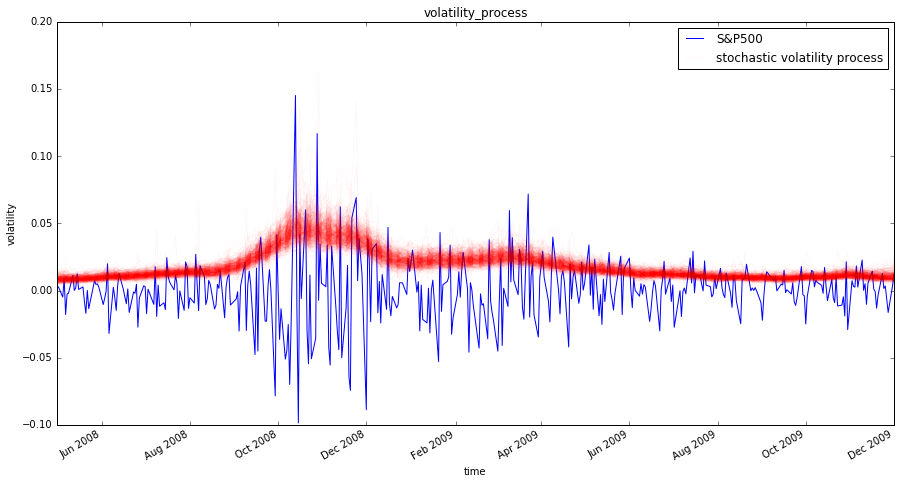

In [7]:
import numpy as np

fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

As you can see, the model correctly infers the increase in volatility during the 2008 financial crash. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.

### Example3: Bayesian Multi-Armed Bandits
*Adapted from an example by Ted Dunning of MapR Technologies*

> Suppose you are faced with $N$ slot machines (colourfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now the prizes are the same for each bandit, only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don't know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings.

Of course, if we knew the bandit with the largest probability, then always picking this bandit would yield the maximum winnings. So our task can be phrased as "Find the best bandit, and as quickly as possible". 

The task is complicated by the stochastic nature of the bandits. A suboptimal bandit can return many winnings, purely by chance, which would make us believe that it is a very profitable bandit. Similarly, the best bandit can return many duds. Should we keep trying losers then, or give up? 

A more troublesome problem is, if we have found a bandit that returns *pretty good* results, do we keep drawing from it to maintain our *pretty good score*, or do we try other bandits in hopes of finding an *even-better* bandit? This is the exploration vs. exploitation dilemma.

##### Applications


The Multi-Armed Bandit problem at first seems very artificial, something only a mathematician would love, but that is only before we address some applications:

- Internet display advertising: companies have a suite of potential ads they can display to visitors, but the company is not sure which ad strategy to follow to maximize sales. This is similar to A/B testing, but has the added advantage of naturally minimizing strategies that do not work (and generalizes to A/B/C/D... strategies)
- Ecology: animals have a finite amount of energy to expend, and following certain behaviours has uncertain rewards. How does the animal maximize its fitness?
- Finance: which stock option gives the highest return, under time-varying return profiles.
- Clinical trials: a researcher would like to find the best treatment, out of many possible treatment, while minimizing losses. 
- Psychology: how does punishment and reward affect our behaviour? How do humans learn?

Many of these questions above are fundamental to the application's field.

It turns out the *optimal solution* is incredibly difficult, and it took decades for an overall solution to develop. There are also many approximately-optimal solutions which are quite good. The one I wish to discuss is one of the few solutions that can scale incredibly well. The solution is known as *Bayesian Bandits*.


##### A Proposed Solution


Any proposed strategy is called an *online algorithm* (not in the internet sense, but in the continuously-being-updated sense), and more specifically a reinforcement learning algorithm. The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviours are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the Multi-Armed Bandit problem:

- Psychology: how does punishment and reward affect our behaviour? How do humans learn?


The Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

That's it. Computationally, the algorithm involves sampling from $N$ distributions. Since the initial priors are $\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution), and the observed result $X$ (a win or loss, encoded 1 and 0 respectfully) is Binomial, the posterior is a $\text{Beta}(\alpha=1+X,\beta=1+1−X)$.

To answer our question from before, this algorithm suggests that we should not discard losers, but we should pick them at a decreasing rate as we gather confidence that there exist *better* bandits. This follows because there is always a non-zero chance that a loser will achieve the status of $B$, but the probability of this event decreases as we play more rounds (see figure below).

Below we implement Bayesian Bandits using two classes, `Bandits` that defines the slot machines, and `BayesianStrategy` which implements the above learning strategy.

In [12]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

Below we visualize the learning of the Bayesian Bandit solution.

In [13]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

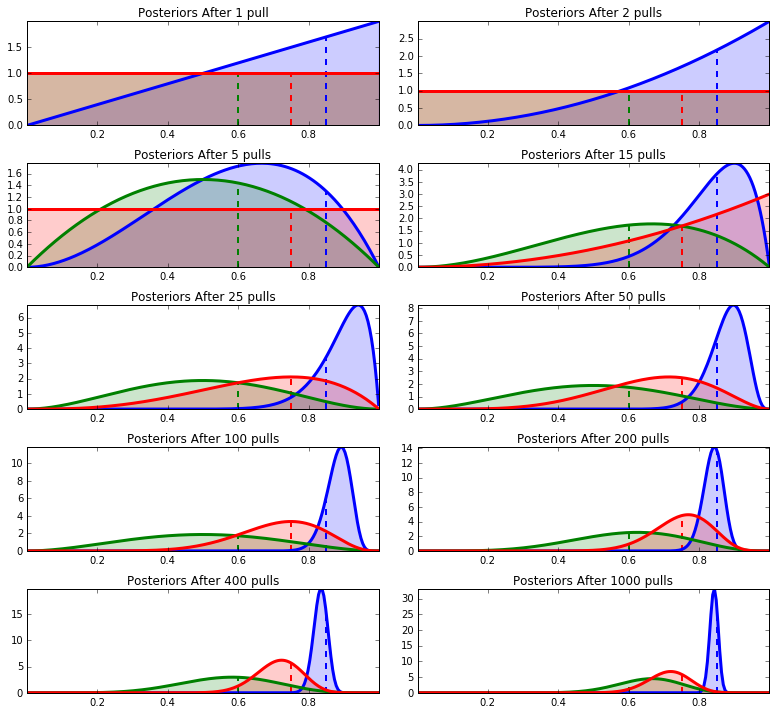

In [14]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

Note that we don't really care how accurate we become about the inference of the hidden probabilities &mdash; for this problem we are more interested in choosing the best bandit (or more accurately, becoming *more confident* in choosing the best bandit). For this reason, the distribution of the red bandit is very wide (representing ignorance about what that hidden probability might be) but we are reasonably confident that it is not the best, so the algorithm chooses to ignore it.

From the above, we can see that after 1000 pulls, the majority of the "blue" function leads the pack, hence we will almost always choose this arm. This is good, as this arm is indeed the best.

Deviations of the observed ratio from the highest probability is a measure of performance. For example,in the long run, optimally we can attain the reward/pull ratio of the maximum bandit probability. Long-term realized ratios less than the maximum represent inefficiencies. (Realized ratios larger than the maximum probability is due to randomness, and will eventually fall below). 

##### A Measure of *Good*

We need a metric to calculate how well we are doing. Recall the absolute *best* we can do is to always pick the bandit with the largest probability of winning. Denote this best bandit's probability by $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best bandit from the beginning. This motivates the *total regret* of a strategy, defined:

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}


where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice.  Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)


Below we plot the total regret of this simulation, including the scores of some other strategies:

1. Random: randomly choose a bandit to pull. If you can't beat this, just stop. 
2. Largest Bayesian credible bound: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. 
3. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior (see [4] )
3. Mean of posterior: choose the bandit with the largest posterior mean. This is what a human player (sans computer) would likely do. 
3. Largest proportion: pick the bandit with the current largest observed proportion of winning. 

The code for these are in the `other_strats.py`, where you can implement your own very easily.

In [15]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

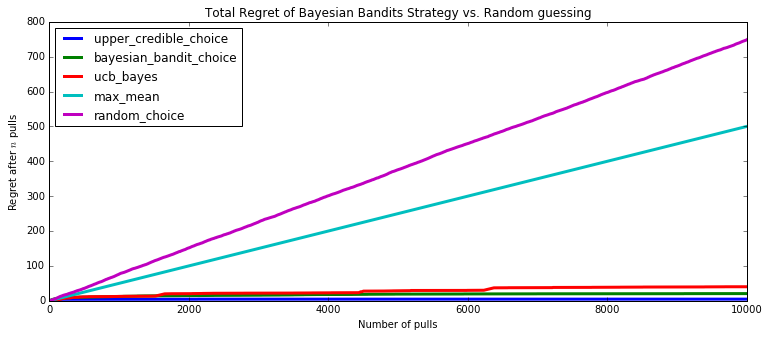

In [16]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

Like we wanted, Bayesian bandits and other strategies have decreasing rates of regret, representing we are achieving optimal choices. To be more scientific so as to remove any possible luck in the above simulation, we should instead look at the *expected total regret*:

$$\bar{R}_T = E[ R_T ] $$

It can be shown that any *sub-optimal* strategy's expected total regret is bounded below logarithmically. Formally,

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

Thus, any strategy that matches logarithmic-growing regret is said to "solve" the Multi-Armed Bandit problem [3].

Using the Law of Large Numbers, we can approximate Bayesian Bandit's expected total regret by performing the same experiment many times (500 times, to be fair):

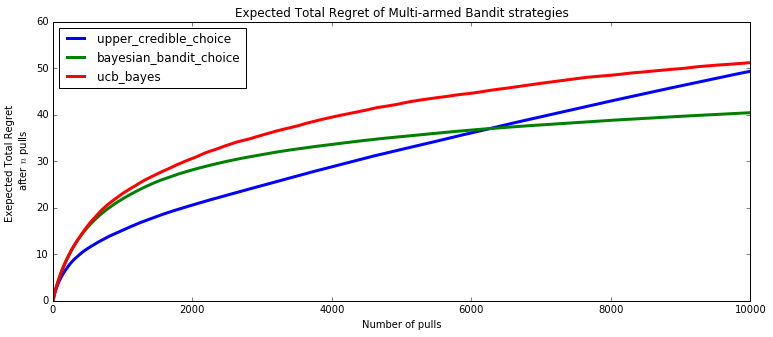

In [17]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

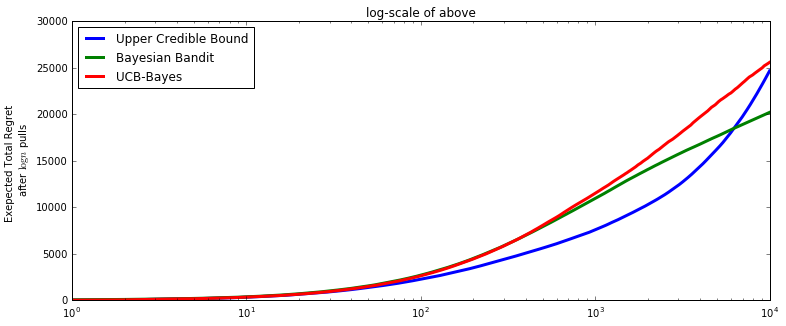

In [18]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

##### Extending the algorithm 


Because of the Bayesian Bandits algorithm's simplicity, it is easy to extend. Some possibilities:

- If interested in the *minimum* probability (eg: where prizes are a bad thing), simply choose $B = \text{argmin} \; X_b$ and proceed.

- Adding learning rates: Suppose the underlying environment may change over time. Technically the standard Bayesian Bandit algorithm would self-update itself (awesome) by noting that what it thought was the best is starting to fail more often. We can motivate the algorithm to learn changing environments quicker by simply adding a *rate* term upon updating:

        self.wins[choice] = rate*self.wins[choice] + result
        self.trials[choice] = rate*self.trials[choice] + 1

   If `rate < 1`, the algorithm will *forget* its previous wins quicker and there will be a downward  pressure towards ignorance. Conversely, setting `rate > 1` implies your algorithm will act more risky, and bet on earlier winners more often and be more resistant to changing environments. 

- Hierarchical algorithms: We can setup a Bayesian Bandit algorithm on top of smaller bandit algorithms. Suppose we have $N$ Bayesian Bandit models, each varying in some behavior (for example  different `rate` parameters, representing varying sensitivity to changing environments). On top of these $N$ models is another Bayesian Bandit learner that will select a sub-Bayesian Bandit. This chosen Bayesian Bandit will then make an internal choice as to which machine to pull. The super-Bayesian Bandit updates itself depending on whether the sub-Bayesian Bandit was correct or not. 

- Extending the rewards, denoted $y_a$ for bandit $a$, to random variables from a distribution $f_{y_a}(y)$ is straightforward. More generally, this problem can be rephrased as "Find the bandit with the largest expected value", as playing the bandit with the largest expected value is optimal. In the case above, $f_{y_a}$ was Bernoulli with probability $p_a$, hence the expected value for a bandit is equal to $p_a$, which is why it looks like we are aiming to maximize the probability of winning. If $f$ is not Bernoulli, and it is non-negative, which can be accomplished apriori by shifting the distribution (we assume we know $f$), then the algorithm behaves as before:

   For each round, 
    
   1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
   2. Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}\;\; X_b$.
   3. Observe the result,$R \sim f_{y_a}$, of pulling bandit $B$, and update your prior on bandit $B$.
   4. Return to 1

   The issue is in the sampling of $X_b$ drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior &mdash; this is easy to sample from. But now, with arbitrary distributions $f$, we have a non-trivial posterior. Sampling from these can be difficult.

- There has been some interest in extending the Bayesian Bandit algorithm to commenting systems. Recall in Chapter 4, we developed a ranking algorithm based on the Bayesian lower-bound of the proportion of upvotes to total votes. One problem with this approach is that it will bias the top rankings towards older comments, since older comments naturally have more votes (and hence the lower-bound is tighter to the true proportion). This creates a positive feedback cycle where older comments gain more votes, hence are displayed more often, hence gain more votes, etc. This pushes any new, potentially better comments, towards the bottom. J. Neufeld proposes a system to remedy this that uses a Bayesian Bandit solution.

His proposal is to consider each comment as a Bandit, with the number of pulls equal to the number of votes cast, and number of rewards as the number of upvotes, hence creating a $\text{Beta}(1+U,1+D)$ posterior. As visitors visit the page, samples are drawn from each bandit/comment, but instead of displaying the comment with the $\max$ sample, the comments are ranked according to the ranking of their respective samples. From J. Neufeld's blog [7]:

   > [The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments. 
   
Just for fun, though the colors explode, we watch the Bayesian Bandit algorithm learn 15 different options. 

[ 0.1044955   0.04620209  0.00384801  0.01134773  0.00564636  0.00960969
  0.01276568  0.03709668  0.03209256  0.06470773  0.25618756  0.01097996
  0.03734185  0.00718132  0.01303514  0.00743637  0.0158191   0.08193681
  0.1448029   0.02722331  0.06832842  0.03836758  0.13875521  0.03674938
  0.03414313  0.13250447  0.06989399  0.17329236  0.01845496  0.21687929
  0.02827149  0.09890236  0.01046578  0.10765764  0.06727824]


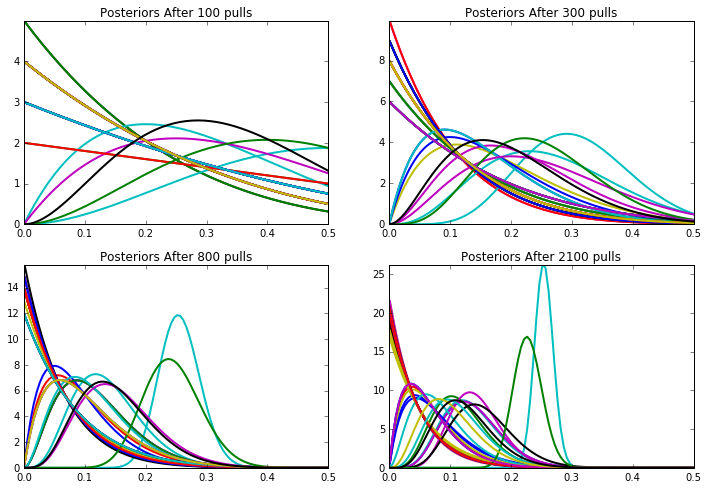

In [19]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)


##### References

1. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo (18 Nov 2011) https://arxiv.org/abs/1111.4246
2. Automatic Differentiation Variational Inference (2 Mar 2016) https://arxiv.org/abs/1603.00788
3. Bayesian Inference for Hackers http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/
4. Probabilistic programming in Python using PyMC3 https://peerj.com/articles/cs-55/
5. Fast Forward Labs http://blog.fastforwardlabs.com/tagged/probabilistic-programming